In [1]:
from pathlib import Path
import os
import json
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnvDSR
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor, MLPFeatureExtractor
from utils import get_data, get_scaled_data_new, get_time_data_new, prepare_aligned_data, daily_portfolio_return, statistics_calc
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_to_env = Path(Path(os.getcwd()).parent, 'data', 'AAPL.csv')

data = pd.read_csv(str(path_to_env), sep=',', index_col='timestamp', parse_dates=True)
#data = data.resample('1D').last()
data.index = data.index.tz_localize(None)
data = data.resample('B').last()
data

,open,high,low,close,volume
timestamp,,,,,
2019-11-13,66.1575,66.1725,66.1125,66.1175,749144.0
2019-11-14,65.6850,65.7100,65.6600,65.6725,1092124.0
2019-11-15,66.3825,66.4450,66.3450,66.4375,2312660.0
2019-11-18,66.7575,66.7900,66.7500,66.7800,924436.0
2019-11-19,66.5725,66.6150,66.5550,66.5725,670616.0
...,...,...,...,...,...
2025-03-13,209.5100,209.7600,209.4900,209.7100,762541.0
2025-03-14,213.6350,213.6600,213.2600,213.3800,1564537.0
2025-03-17,214.1800,214.2200,213.9000,214.1500,1161314.0


In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 30,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 20,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

In [3]:
# Фиксация сидов для воспроизводимости
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def create_env(data, scaled_data, time_data, config, mode='train'):
    """Создает окружение с синхронизированными данными"""
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    
    # Создаем маску для выбранного периода
    if mode == 'train':
        mask = (data.index >= train_start) & (data.index <= train_end)
    else:
        mask = (data.index >= val_start) & (data.index <= val_end)
    
    # Применяем маску
    data_segment = data[mask] # исторические данные OLHC
    scaled_segment = scaled_data[mask] # признаковое описание (тех индикаторы и тд)
    time_segment = time_data[mask] # временные признаки
    
    # Проверка согласованности
    assert len(data_segment) == len(scaled_segment) == len(time_segment), \
        f"Размеры не совпадают: data={len(data_segment)}, scaled={len(scaled_segment)}, time={len(time_segment)}"
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    return make_vec_env(
        lambda: StockTradingEnvDSR(**env_kwargs),
        n_envs=1,
        vec_env_cls=DummyVecEnv
    )


# Конфигурация модели
def get_model_config(model_type, trial=None):
    """Возвращает конфигурацию для выбранного типа модели"""
    base_config = {
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [8]:
def train_model(config, trial=None):
    """Обучает модель с заданной конфигурацией"""
    set_seeds(config["seed"])
    
    # Получаем синхронизированные данные
    data_array, scaled_array, time_array, full_index = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения
    env_train = create_env(data_array, scaled_array, time_array, config, 'train')
    env_val = create_env(data_array, scaled_array, time_array, config, 'val')

    params = config["default_params"].copy()

    tb_log = params.pop("tensorboard_log")
    tb_log_path = f"save/{tb_log}/{config['model_type']}_{trial.number if trial else 'default'}"

    if trial:
        params.update({
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.999),
            "exploration_fraction": trial.suggest_float("exploration_fraction", 0.1, 0.5),
            "buffer_size": trial.suggest_int("buffer_size", 5000, 100000)
        })
    
    model_config = get_model_config(config["model_type"], trial=trial)

    model = DQN(
        "MlpPolicy",
        env_train,
        policy_kwargs=model_config,
        verbose=1,
        tensorboard_log=tb_log_path,
        #replay_buffer_kwargs=dict(optimize_memory_usage=True),
        device="auto",
        **params
    )

    print(model_config)
    model.learn(
        total_timesteps=500000,
        callback=ProgressBarCallback(),
        log_interval=100,
        tb_log_name=f"{config['model_type']}_{trial.number if trial else 'default'}"
    )
    print('Обучение завершено')
    #sharpe_ratio, returns, b_h_ret = evaluate_daily_sharpe(model, env_val)
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    if not trial:
        save_path = Path("models", f"{config['ticker']}_{config['model_type']}")
        model.save(str(save_path))
    
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='val', ticker=CONFIG['ticker'])
    return metrics, returns, b_h_ret, model

def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19])
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    metrics, p1, p2, p3 = train_model(config, trial)
    return 0.7 * metrics["Sharpe ratio"].values[0] + 0.3 * metrics["Annual return"].values[0]

[I 2025-07-03 18:39:14,549] A new study created in memory with name: no-name-af5cca14-515b-44d6-997c-231523ba8cfe


  0%|          | 0/20 [00:00<?, ?it/s]

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 110}}
Logging to save/logs//Linear_0\Linear_0_5


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 55.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 754      |
|    time_elapsed     | 89       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 2.94e-05 |
|    loss             | 0.425    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


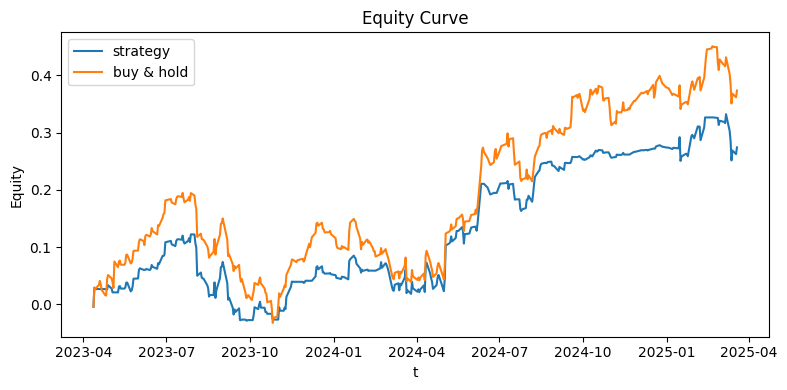

[I 2025-07-03 18:41:39,032] Trial 0 finished with value: 0.9630096371652241 and parameters: {'window_size': 60, 'lr': 2.9380279387035334e-05, 'batch_size': 128, 'gamma': 0.9700991852018085, 'exploration_frac': 0.10823379771832098, 'buffer_size': 97142, 'linear_dim': 110, 'rnn_dim': 79, 'rnn_hidden': 145, 'lstm_dim': 73, 'lstm_hidden': 200}. Best is trial 0 with value: 0.9630096371652241.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 21}}
Logging to save/logs//Linear_1\Linear_1_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | 5.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 615      |
|    time_elapsed     | 99       |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 2.62e-05 |
|    loss             | 0.306    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


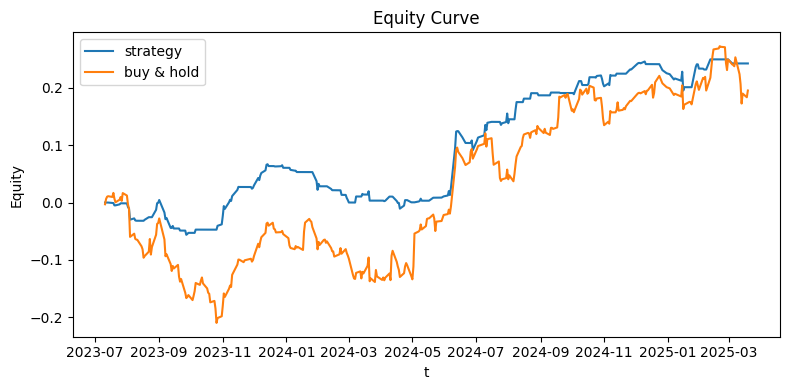

[I 2025-07-03 18:44:34,336] Trial 1 finished with value: 1.421230604736508 and parameters: {'window_size': 120, 'lr': 2.621087878265438e-05, 'batch_size': 256, 'gamma': 0.9197677044336776, 'exploration_frac': 0.3056937753654446, 'buffer_size': 61279, 'linear_dim': 21, 'rnn_dim': 168, 'rnn_hidden': 140, 'lstm_dim': 46, 'lstm_hidden': 490}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 51}}
Logging to save/logs//Linear_2\Linear_2_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 704      |
|    ep_rew_mean      | 106      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1094     |
|    time_elapsed     | 64       |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 0.00113  |
|    loss             | 0.273    |
|    n_updates        | 15099    |
----------------------------------


Обучение завершено


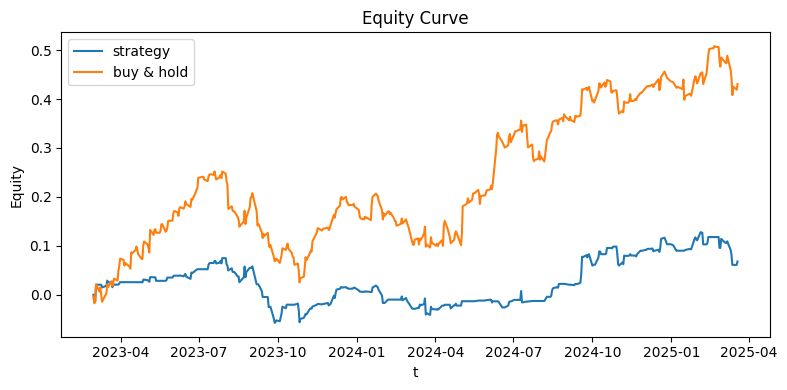

[I 2025-07-03 18:46:12,943] Trial 2 finished with value: 0.3304835111272879 and parameters: {'window_size': 30, 'lr': 0.0011290133559092666, 'batch_size': 128, 'gamma': 0.9900227198057994, 'exploration_frac': 0.20351199264000677, 'buffer_size': 67940, 'linear_dim': 51, 'rnn_dim': 149, 'rnn_hidden': 309, 'lstm_dim': 73, 'lstm_hidden': 499}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 56}}
Logging to save/logs//Linear_3\Linear_3_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 55       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 735      |
|    time_elapsed     | 91       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.00583  |
|    loss             | 0.502    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


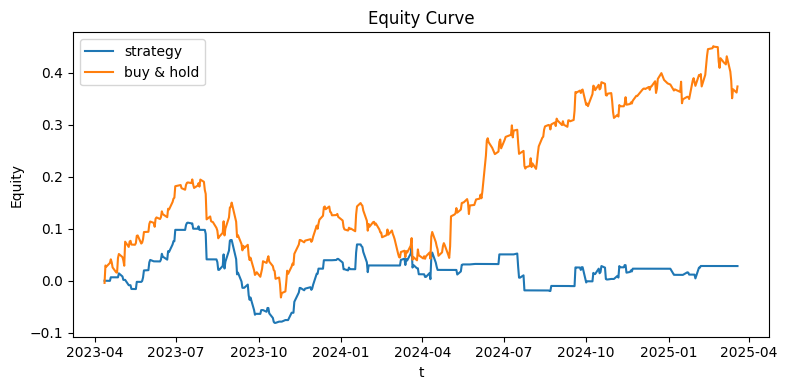

[I 2025-07-03 18:48:38,848] Trial 3 finished with value: 0.1227574530339493 and parameters: {'window_size': 60, 'lr': 0.00582938454299474, 'batch_size': 256, 'gamma': 0.9384790516792587, 'exploration_frac': 0.20853961270955837, 'buffer_size': 83730, 'linear_dim': 56, 'rnn_dim': 95, 'rnn_hidden': 307, 'lstm_dim': 63, 'lstm_hidden': 424}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 113}}
Logging to save/logs//Linear_4\Linear_4_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 31       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1007     |
|    time_elapsed     | 66       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 1.04e-05 |
|    loss             | 0.386    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


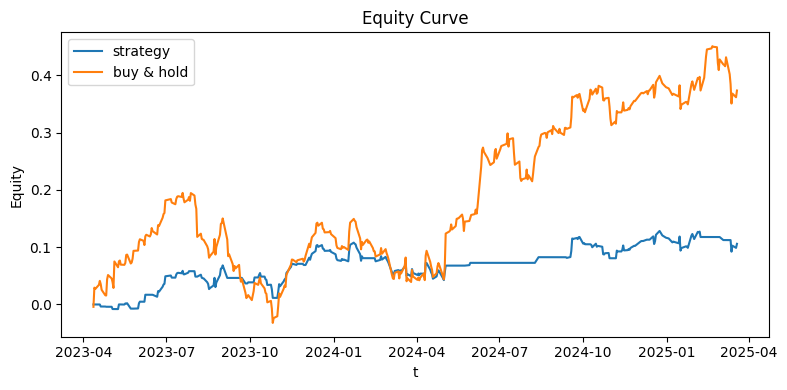

[I 2025-07-03 18:50:24,636] Trial 4 finished with value: 0.6806641939942559 and parameters: {'window_size': 60, 'lr': 1.0388823104027935e-05, 'batch_size': 32, 'gamma': 0.907330420521675, 'exploration_frac': 0.24338629141770907, 'buffer_size': 16007, 'linear_dim': 113, 'rnn_dim': 172, 'rnn_hidden': 212, 'lstm_dim': 46, 'lstm_hidden': 203}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 64}}
Logging to save/logs//Linear_5\Linear_5_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | -28.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 729      |
|    time_elapsed     | 84       |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 0.000261 |
|    loss             | 0.294    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


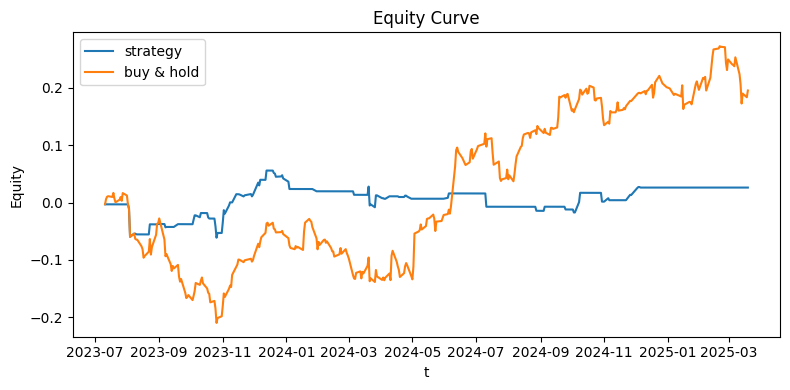

[I 2025-07-03 18:52:57,296] Trial 5 finished with value: 0.2029837270074586 and parameters: {'window_size': 120, 'lr': 0.00026100256506134784, 'batch_size': 128, 'gamma': 0.9763257508155015, 'exploration_frac': 0.2975182385457563, 'buffer_size': 54660, 'linear_dim': 64, 'rnn_dim': 37, 'rnn_hidden': 112, 'lstm_dim': 39, 'lstm_hidden': 349}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 87}}
Logging to save/logs//Linear_6\Linear_6_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 644      |
|    ep_rew_mean      | 31.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1027     |
|    time_elapsed     | 62       |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 0.00017  |
|    loss             | 0.174    |
|    n_updates        | 13599    |
----------------------------------


Обучение завершено


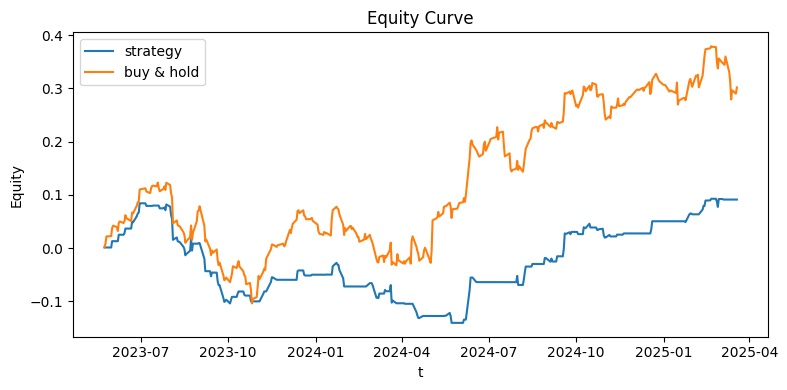

[I 2025-07-03 18:54:48,243] Trial 6 finished with value: 0.4961508612346114 and parameters: {'window_size': 90, 'lr': 0.0001702741688676439, 'batch_size': 32, 'gamma': 0.9159609074381465, 'exploration_frac': 0.47187906093702925, 'buffer_size': 81772, 'linear_dim': 87, 'rnn_dim': 228, 'rnn_hidden': 424, 'lstm_dim': 73, 'lstm_hidden': 464}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 41}}
Logging to save/logs//Linear_7\Linear_7_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 644      |
|    ep_rew_mean      | -1.86    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 587      |
|    time_elapsed     | 109      |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 2.14e-05 |
|    loss             | 0.297    |
|    n_updates        | 13599    |
----------------------------------


Обучение завершено


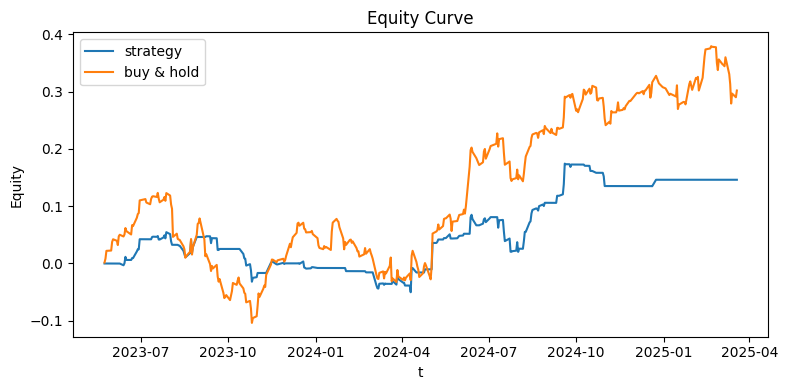

[I 2025-07-03 18:57:45,289] Trial 7 finished with value: 0.8432499849915437 and parameters: {'window_size': 90, 'lr': 2.1387290754148914e-05, 'batch_size': 256, 'gamma': 0.9006882609225879, 'exploration_frac': 0.3042989210310263, 'buffer_size': 44654, 'linear_dim': 41, 'rnn_dim': 58, 'rnn_hidden': 215, 'lstm_dim': 244, 'lstm_hidden': 209}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 21}}
Logging to save/logs//Linear_8\Linear_8_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | -120     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1117     |
|    time_elapsed     | 54       |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 0.00772  |
|    loss             | 0.706    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


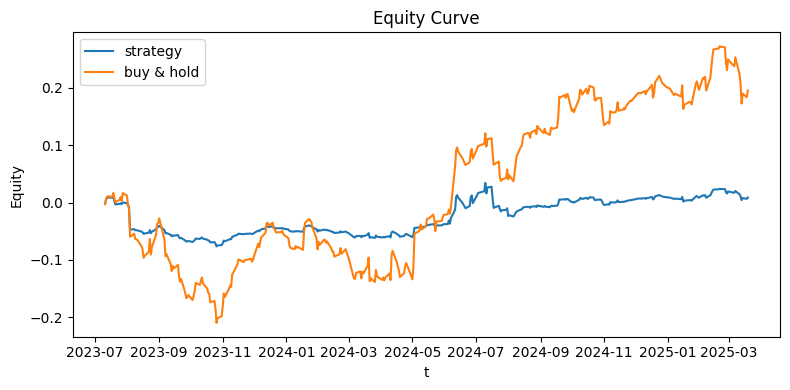

[I 2025-07-03 18:59:25,073] Trial 8 finished with value: 0.08039352591724094 and parameters: {'window_size': 120, 'lr': 0.007715105777813051, 'batch_size': 64, 'gamma': 0.9036518077880987, 'exploration_frac': 0.3438257335919588, 'buffer_size': 52755, 'linear_dim': 21, 'rnn_dim': 94, 'rnn_hidden': 471, 'lstm_dim': 85, 'lstm_hidden': 129}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 110}}
Logging to save/logs//Linear_9\Linear_9_3


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 50.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 959      |
|    time_elapsed     | 70       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.00193  |
|    loss             | 0.294    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


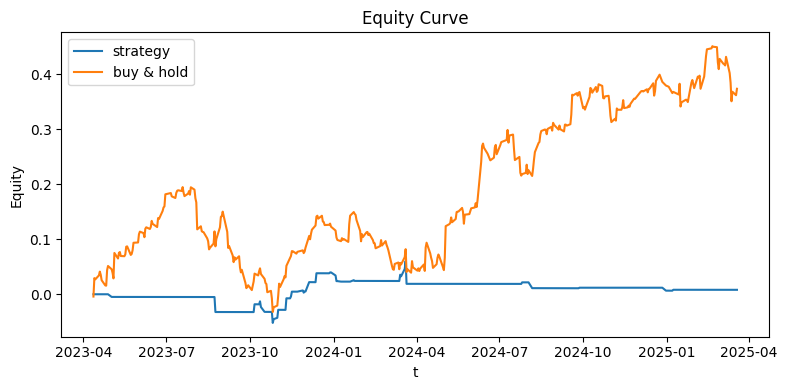

[I 2025-07-03 19:01:18,523] Trial 9 finished with value: 0.07735120739466073 and parameters: {'window_size': 60, 'lr': 0.0019268985325226215, 'batch_size': 64, 'gamma': 0.9627194413653286, 'exploration_frac': 0.31430987362990337, 'buffer_size': 13577, 'linear_dim': 110, 'rnn_dim': 104, 'rnn_hidden': 147, 'lstm_dim': 41, 'lstm_hidden': 329}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 17}}
Logging to save/logs//Linear_10\Linear_10_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | -13.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 689      |
|    time_elapsed     | 88       |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 7.65e-05 |
|    loss             | 0.2      |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


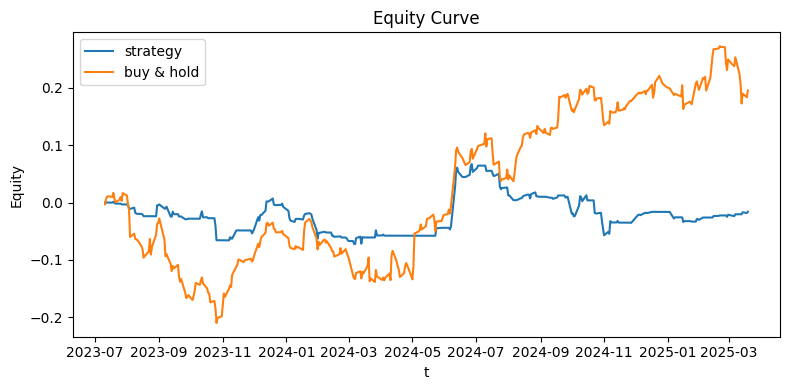

[I 2025-07-03 19:03:57,048] Trial 10 finished with value: -0.09684205650710417 and parameters: {'window_size': 120, 'lr': 7.651272141735043e-05, 'batch_size': 256, 'gamma': 0.9328823365767158, 'exploration_frac': 0.4164429485372938, 'buffer_size': 33553, 'linear_dim': 17, 'rnn_dim': 213, 'rnn_hidden': 80, 'lstm_dim': 150, 'lstm_hidden': 386}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 89}}
Logging to save/logs//Linear_11\Linear_11_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 704      |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1019     |
|    time_elapsed     | 69       |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 4.42e-05 |
|    loss             | 0.278    |
|    n_updates        | 15099    |
----------------------------------


Обучение завершено


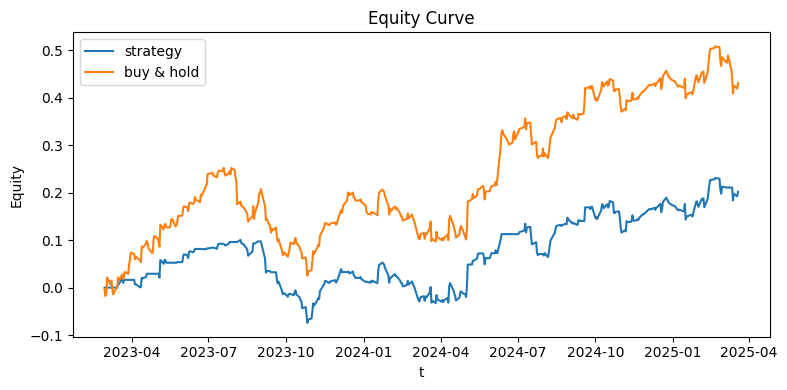

[I 2025-07-03 19:05:42,433] Trial 11 finished with value: 0.7775914568156295 and parameters: {'window_size': 30, 'lr': 4.4231559450958525e-05, 'batch_size': 128, 'gamma': 0.9560228498993807, 'exploration_frac': 0.12794147242235573, 'buffer_size': 98099, 'linear_dim': 89, 'rnn_dim': 187, 'rnn_hidden': 193, 'lstm_dim': 126, 'lstm_hidden': 248}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 126}}
Logging to save/logs//Linear_12\Linear_12_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 353      |
|    time_elapsed     | 173      |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 4.88e-05 |
|    loss             | 0.245    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


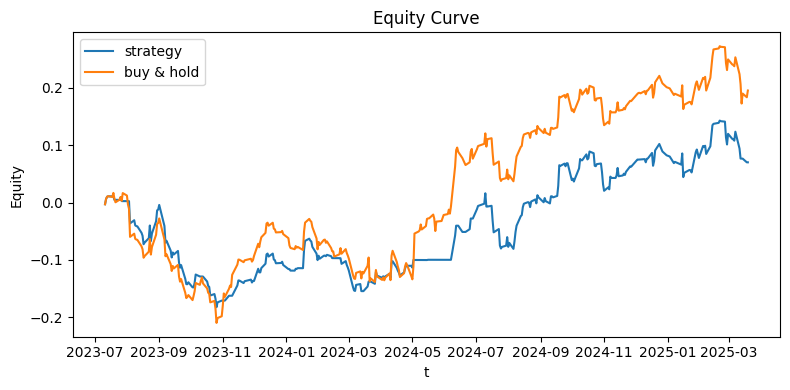

[I 2025-07-03 19:12:34,946] Trial 12 finished with value: 0.28149708705561793 and parameters: {'window_size': 120, 'lr': 4.8816483080633704e-05, 'batch_size': 256, 'gamma': 0.9732732274605813, 'exploration_frac': 0.10792832283199982, 'buffer_size': 99622, 'linear_dim': 126, 'rnn_dim': 127, 'rnn_hidden': 65, 'lstm_dim': 119, 'lstm_hidden': 75}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 82}}
Logging to save/logs//Linear_13\Linear_13_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 66.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 913      |
|    time_elapsed     | 73       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 1.41e-05 |
|    loss             | 0.342    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


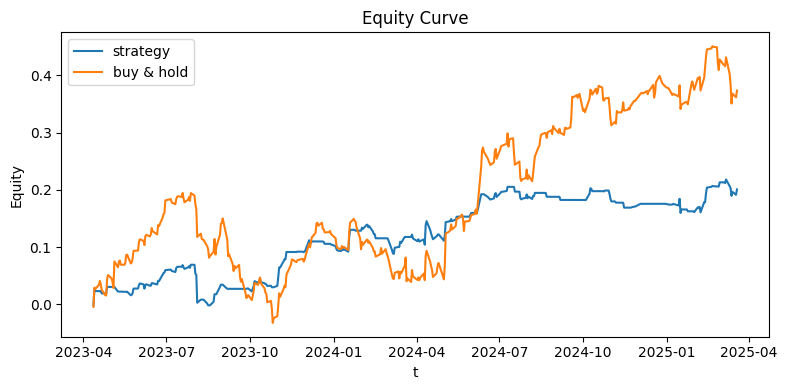

[I 2025-07-03 19:14:34,747] Trial 13 finished with value: 1.2008207447315289 and parameters: {'window_size': 60, 'lr': 1.4138759313828848e-05, 'batch_size': 128, 'gamma': 0.9285061691948063, 'exploration_frac': 0.37288240486632385, 'buffer_size': 74348, 'linear_dim': 82, 'rnn_dim': 256, 'rnn_hidden': 164, 'lstm_dim': 159, 'lstm_hidden': 292}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 83}}
Logging to save/logs//Linear_14\Linear_14_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 93.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 689      |
|    time_elapsed     | 97       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 1.11e-05 |
|    loss             | 1.09     |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


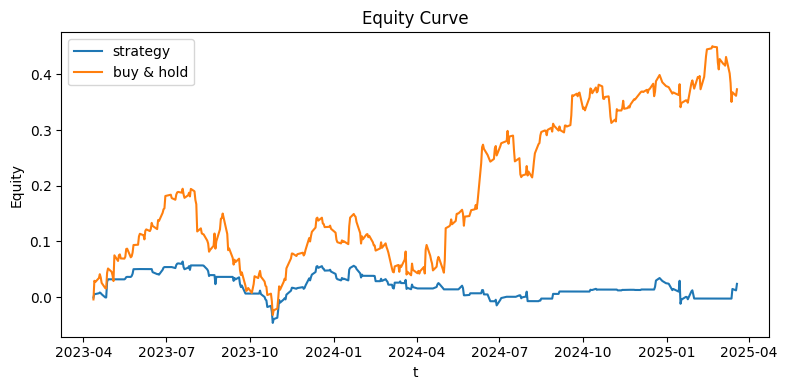

[I 2025-07-03 19:17:11,369] Trial 14 finished with value: 0.1664709539472421 and parameters: {'window_size': 60, 'lr': 1.1128738110354669e-05, 'batch_size': 256, 'gamma': 0.9250260184656004, 'exploration_frac': 0.4009655434547191, 'buffer_size': 67748, 'linear_dim': 83, 'rnn_dim': 252, 'rnn_hidden': 265, 'lstm_dim': 186, 'lstm_hidden': 424}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 38}}
Logging to save/logs//Linear_15\Linear_15_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | 4.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 811      |
|    time_elapsed     | 75       |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 0.000103 |
|    loss             | 0.347    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


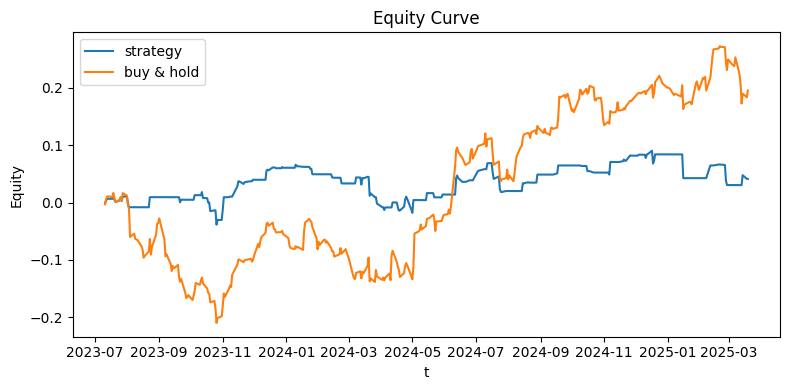

[I 2025-07-03 19:19:26,672] Trial 15 finished with value: 0.26573328009937425 and parameters: {'window_size': 120, 'lr': 0.0001034840029940205, 'batch_size': 128, 'gamma': 0.9473047482638518, 'exploration_frac': 0.3788325259960595, 'buffer_size': 67429, 'linear_dim': 38, 'rnn_dim': 190, 'rnn_hidden': 364, 'lstm_dim': 187, 'lstm_hidden': 291}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 71}}
Logging to save/logs//Linear_16\Linear_16_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 704      |
|    ep_rew_mean      | 68.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1255     |
|    time_elapsed     | 56       |
|    total_timesteps  | 70400    |
| train/              |          |
|    learning_rate    | 0.000721 |
|    loss             | 0.406    |
|    n_updates        | 15099    |
----------------------------------


Обучение завершено


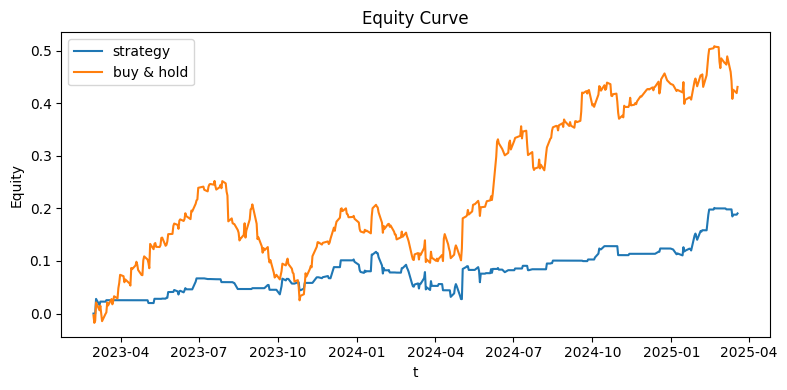

[I 2025-07-03 19:20:53,533] Trial 16 finished with value: 1.0430972376252514 and parameters: {'window_size': 30, 'lr': 0.0007206925129037642, 'batch_size': 64, 'gamma': 0.9220622733629489, 'exploration_frac': 0.4982797687818511, 'buffer_size': 34703, 'linear_dim': 71, 'rnn_dim': 249, 'rnn_hidden': 165, 'lstm_dim': 180, 'lstm_hidden': 494}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 33}}
Logging to save/logs//Linear_17\Linear_17_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 644      |
|    ep_rew_mean      | 36.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1287     |
|    time_elapsed     | 50       |
|    total_timesteps  | 64400    |
| train/              |          |
|    learning_rate    | 1.98e-05 |
|    loss             | 0.207    |
|    n_updates        | 13599    |
----------------------------------


Обучение завершено


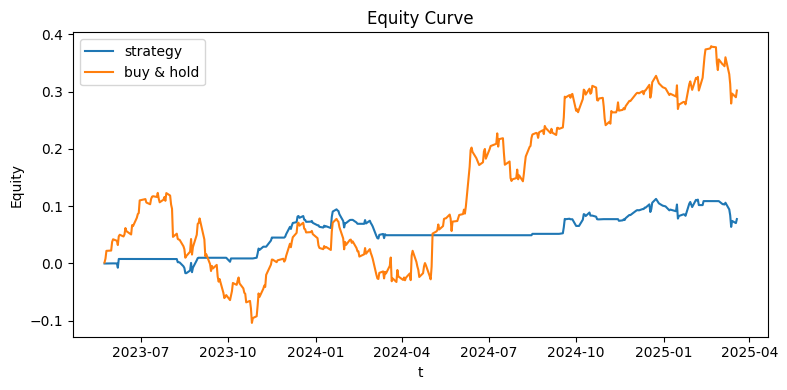

[I 2025-07-03 19:22:20,353] Trial 17 finished with value: 0.6679196275754731 and parameters: {'window_size': 90, 'lr': 1.9775900430007732e-05, 'batch_size': 32, 'gamma': 0.9395301701835619, 'exploration_frac': 0.2569506910739981, 'buffer_size': 79046, 'linear_dim': 33, 'rnn_dim': 157, 'rnn_hidden': 257, 'lstm_dim': 237, 'lstm_hidden': 287}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 94}}
Logging to save/logs//Linear_18\Linear_18_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 674      |
|    ep_rew_mean      | 38.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 899      |
|    time_elapsed     | 74       |
|    total_timesteps  | 67400    |
| train/              |          |
|    learning_rate    | 0.000497 |
|    loss             | 0.653    |
|    n_updates        | 14349    |
----------------------------------


Обучение завершено


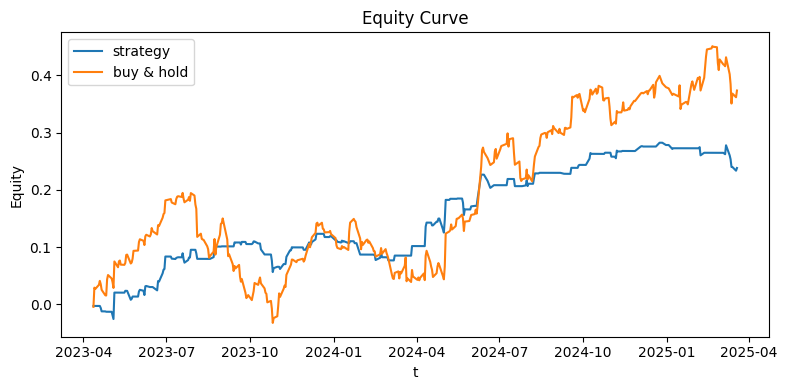

[I 2025-07-03 19:24:20,791] Trial 18 finished with value: 1.3606313192218251 and parameters: {'window_size': 60, 'lr': 0.0004972241489875053, 'batch_size': 128, 'gamma': 0.9163880173190704, 'exploration_frac': 0.44371776082515424, 'buffer_size': 59799, 'linear_dim': 94, 'rnn_dim': 220, 'rnn_hidden': 105, 'lstm_dim': 102, 'lstm_hidden': 134}. Best is trial 1 with value: 1.421230604736508.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 98}}
Logging to save/logs//Linear_19\Linear_19_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 614      |
|    ep_rew_mean      | -27.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 484      |
|    time_elapsed     | 126      |
|    total_timesteps  | 61400    |
| train/              |          |
|    learning_rate    | 0.000473 |
|    loss             | 0.343    |
|    n_updates        | 12849    |
----------------------------------


Обучение завершено


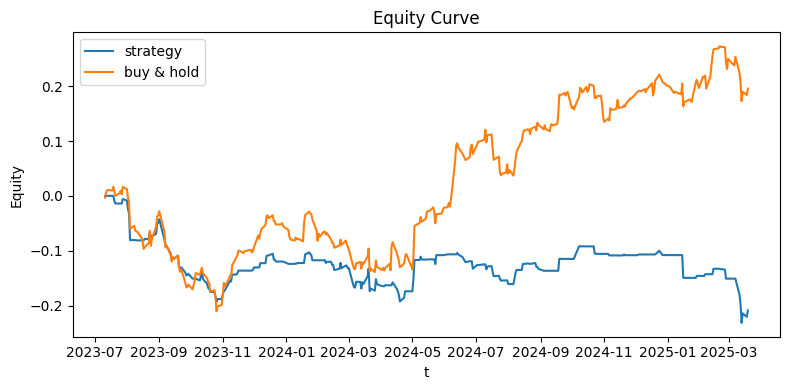

[I 2025-07-03 19:28:07,527] Trial 19 finished with value: -1.098598455776025 and parameters: {'window_size': 120, 'lr': 0.0004731472126962528, 'batch_size': 256, 'gamma': 0.9138967736770799, 'exploration_frac': 0.43786291026285984, 'buffer_size': 41509, 'linear_dim': 98, 'rnn_dim': 212, 'rnn_hidden': 105, 'lstm_dim': 105, 'lstm_hidden': 141}. Best is trial 1 with value: 1.421230604736508.
Лучшие параметры: {'window_size': 120, 'lr': 2.621087878265438e-05, 'batch_size': 256, 'gamma': 0.9197677044336776, 'exploration_frac': 0.3056937753654446, 'buffer_size': 61279, 'linear_dim': 21, 'rnn_dim': 168, 'rnn_hidden': 140, 'lstm_dim': 46, 'lstm_hidden': 490}
Лучшая награда: 1.421230604736508
Shape of data: (1396, 6) 2019-11-13 00:00:00


TypeError: DQN.__init__() got an unexpected keyword argument 'lr'

In [5]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

# Тест модели на лучших параметрах

In [5]:
path_to_params = Path(os.getcwd()).parent / 'params_models' / 'best_params_DQN_1.json'
with open(path_to_params, 'r') as f:
    best_params = json.load(f)

In [18]:
best_params

{'window_size': 120,
 'learning_rate': 2.621087878265438e-05,
 'batch_size': 256,
 'gamma': 0.9197677044336776,
 'exploration_fraction': 0.3056937753654446,
 'buffer_size': 61279,
 'linear_dim': 21,
 'rnn_dim': 168,
 'rnn_hidden': 140,
 'lstm_dim': 46,
 'lstm_hidden': 490}

In [23]:
CONFIG

{'ticker': 'AAPL',
 'model_type': 'Linear',
 'window_size': 120,
 'price_column': 3,
 'num_actions': 11,
 'train_period': ('2019-11-13', '2023-01-11'),
 'val_period': ('2023-01-11', '2025-03-19'),
 'seed': 42,
 'default_params': {'learning_rate': 2.621087878265438e-05,
  'buffer_size': 61279,
  'learning_starts': 10000,
  'batch_size': 256,
  'gamma': 0.9197677044336776,
  'exploration_fraction': 0.3056937753654446,
  'exploration_initial_eps': 0.9,
  'exploration_final_eps': 0.05,
  'tensorboard_log': 'logs/'},
 'optuna': {'n_trials': 20, 'timeout': 7200, 'direction': 'maximize'}}

# AAPL

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_70


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | -40.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 567      |
|    time_elapsed     | 152      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 2.62e-05 |
|    loss             | 0.251    |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


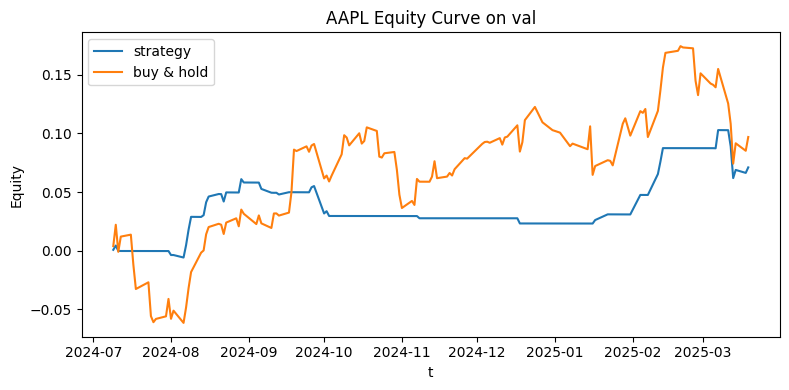

Metrics on val:
Sharpe ratio: 1.954915711512879, annual return: 0.19219730070039726, volatility: 0.09831487852315574


In [6]:
CONFIG["window_size"] = best_params["window_size"]
del best_params["window_size"]
CONFIG["default_params"].update({
    k: v for k, v in best_params.items() 
    if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
})

metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (1396, 6) 2019-11-13 00:00:00


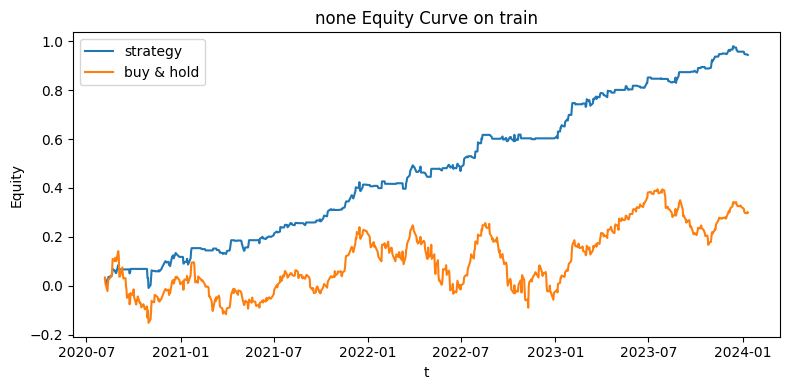

Metrics on train:
Sharpe ratio: 3.1274249935412133, annual return: 0.5067841810315356, volatility: 0.16204519119663968


In [7]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

# AMZN

In [8]:
CONFIG = {
    "ticker": "AMZN",
    "model_type": "Linear",
    "window_size": 20,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

path_to_params = Path(os.getcwd()).parent / 'params_models' / 'best_params_DQN_1.json'
with open(path_to_params, 'r') as f:
    best_params = json.load(f)

CONFIG["window_size"] = best_params["window_size"]
del best_params["window_size"]
CONFIG["default_params"].update({
    k: v for k, v in best_params.items() 
    if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
})

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_71


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 587      |
|    time_elapsed     | 147      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 2.62e-05 |
|    loss             | 0.253    |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


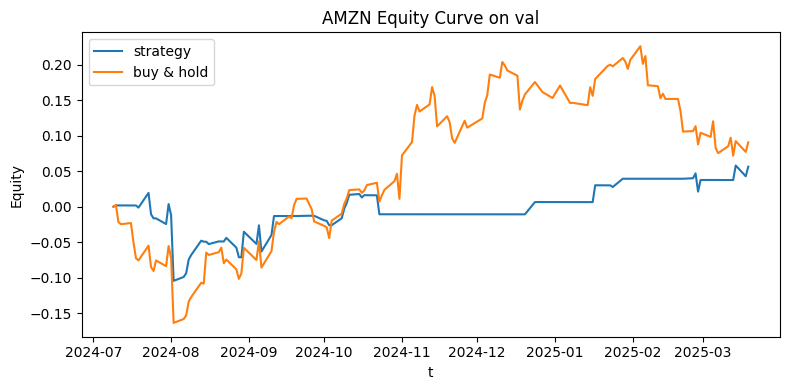

Metrics on val:
Sharpe ratio: 0.6346356213074191, annual return: 0.1523488629309207, volatility: 0.2400572199478266


In [9]:
metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (1396, 6) 2019-11-13 00:00:00


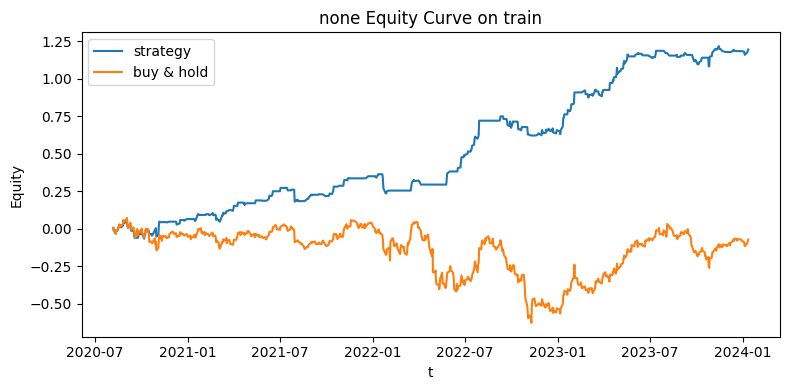

Metrics on train:
Sharpe ratio: 2.4495947246211585, annual return: 0.6417654706562201, volatility: 0.2619884278022652


In [10]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

# MSFT

In [11]:
CONFIG = {
    "ticker": "MSFT",
    "model_type": "Linear",
    "window_size": 20,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

path_to_params = Path(os.getcwd()).parent / 'params_models' / 'best_params_DQN_1.json'
with open(path_to_params, 'r') as f:
    best_params = json.load(f)

CONFIG["window_size"] = best_params["window_size"]
del best_params["window_size"]
CONFIG["default_params"].update({
    k: v for k, v in best_params.items() 
    if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
})

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_72


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | 20.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 546      |
|    time_elapsed     | 158      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 2.62e-05 |
|    loss             | 0.17     |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


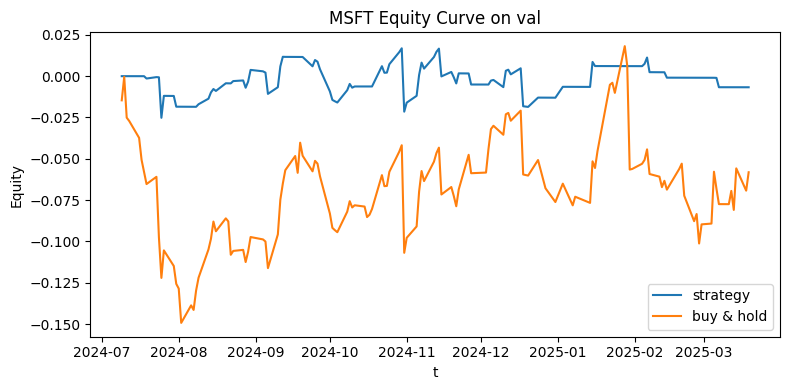

Metrics on val:
Sharpe ratio: -0.1523651345315892, annual return: -0.018172965914211078, volatility: 0.1192724698473807


In [12]:
metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (1396, 6) 2019-11-13 00:00:00


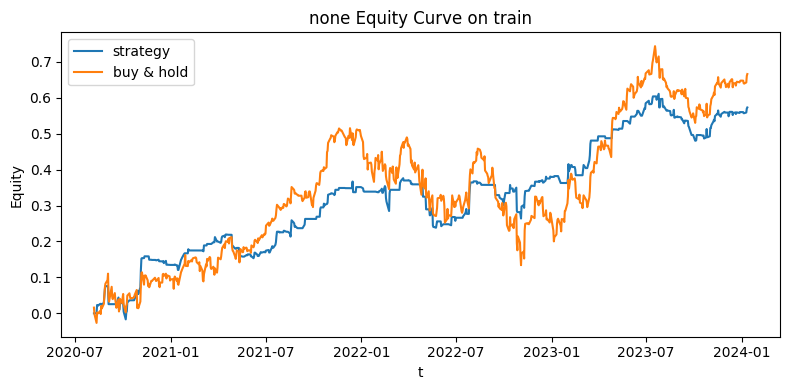

Metrics on train:
Sharpe ratio: 1.6718646324937612, annual return: 0.3078326576697886, volatility: 0.1841253482410379


In [13]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

# Запуск модели с более глубокой архитектурой сети для LinearFeatureExtractor

In [5]:
def get_model_config(model_type, trial=None):
    base_config = {
        "MLP": {
            "features_extractor_class": MLPFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("mlp_dim", 32, 128) if trial else 64,
                "hidden_layers": [
                    trial.suggest_int("mlp_layer1", 128, 512) if trial else 256,
                    trial.suggest_int("mlp_layer2", 64, 256) if trial else 128
                ],
                "dropout": trial.suggest_float("dropout", 0.1, 0.5) if trial else 0.2
            }
        },
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [6]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "MLP",
    "window_size": 20,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 20,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

path_to_params = Path(os.getcwd()).parent / 'params_models' / 'best_params_DQN_1.json'
with open(path_to_params, 'r') as f:
    best_params = json.load(f)

CONFIG["window_size"] = best_params["window_size"]
del best_params["window_size"]
CONFIG["default_params"].update({
    k: v for k, v in best_params.items() 
    if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
})

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 64, 'hidden_layers': [256, 128], 'dropout': 0.2}}
Logging to save/logs//MLP_default\MLP_default_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 214      |
|    time_elapsed     | 402      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 2.62e-05 |
|    loss             | 0.625    |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


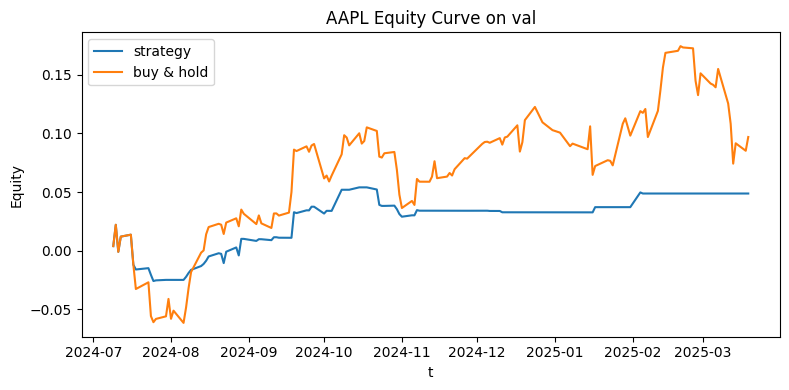

Metrics on val:
Sharpe ratio: 1.3516694808634424, annual return: 0.13196107784881073, volatility: 0.09762821438012671


In [8]:
metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (1396, 6) 2019-11-13 00:00:00


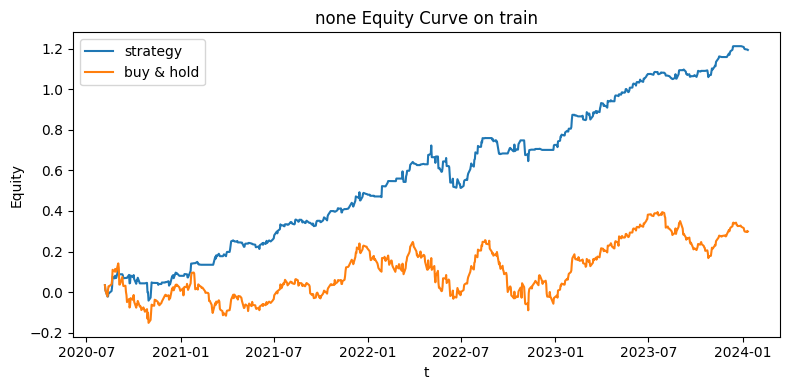

Metrics on train:
Sharpe ratio: 2.617726208208222, annual return: 0.6408143711044598, volatility: 0.24479808816334678


In [9]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

[I 2025-07-04 15:20:30,308] A new study created in memory with name: no-name-50bc0a1e-5afa-40ad-a96f-4aaf30b9417a


  0%|          | 0/20 [00:00<?, ?it/s]

Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 61, 'hidden_layers': [330, 147], 'dropout': 0.21649165607921678}}
Logging to save/logs//MLP_0\MLP_0_2


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 925      |
|    ep_rew_mean      | 68.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 384      |
|    time_elapsed     | 240      |
|    total_timesteps  | 92500    |
| train/              |          |
|    learning_rate    | 0.000636 |
|    loss             | 0.243    |
|    n_updates        | 20624    |
----------------------------------


Обучение завершено


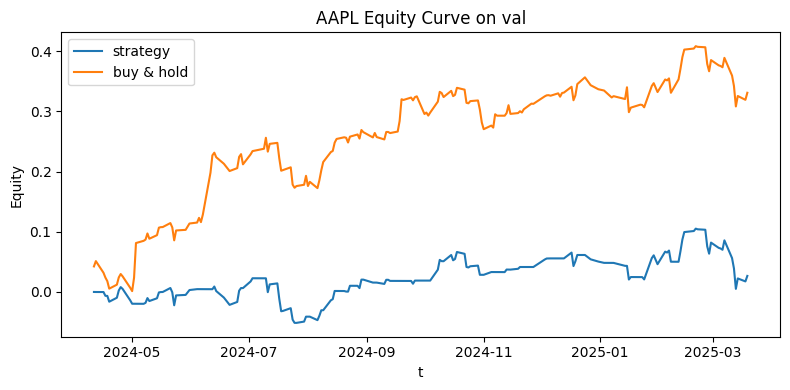

Metrics on val:
Sharpe ratio: 0.2941546488756044, annual return: 0.05404884418439583, volatility: 0.18374295422831358
[I 2025-07-04 15:24:56,992] Trial 0 finished with value: 0.22212290746824181 and parameters: {'window_size': 60, 'num_actions': 19, 'learning_rate': 0.0006358358856676254, 'batch_size': 128, 'gamma': 0.9210215719571494, 'exploration_fraction': 0.17272998688284025, 'buffer_size': 22423, 'mlp_dim': 61, 'mlp_layer1': 330, 'mlp_layer2': 147, 'dropout': 0.21649165607921678, 'linear_dim': 85, 'rnn_dim': 63, 'rnn_hidden': 195, 'lstm_dim': 114, 'lstm_hidden': 268}. Best is trial 0 with value: 0.22212290746824181.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 80, 'hidden_layers': [141, 239], 'dropout': 0.20351199264000677}}
Logging to save/logs//MLP_1\MLP_1_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 955      |
|    ep_rew_mean      | 242      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 729      |
|    time_elapsed     | 130      |
|    total_timesteps  | 95500    |
| train/              |          |
|    learning_rate    | 0.00703  |
|    loss             | 0.546    |
|    n_updates        | 21374    |
----------------------------------


Обучение завершено


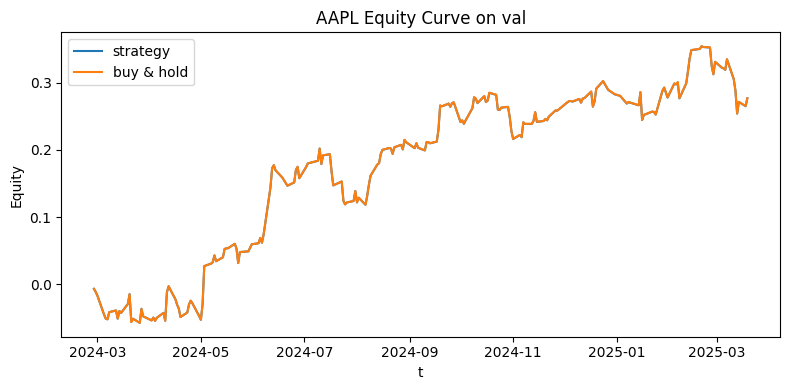

Metrics on val:
Sharpe ratio: 1.7825403620801994, annual return: 0.4953741516939064, volatility: 0.2779034698074448
[I 2025-07-04 15:27:17,560] Trial 1 finished with value: 1.3963904989643114 and parameters: {'window_size': 30, 'num_actions': 5, 'learning_rate': 0.007025166339242158, 'batch_size': 32, 'gamma': 0.9677390696247036, 'exploration_fraction': 0.27606099749584057, 'buffer_size': 16593, 'mlp_dim': 80, 'mlp_layer1': 141, 'mlp_layer2': 239, 'dropout': 0.20351199264000677, 'linear_dim': 90, 'rnn_dim': 102, 'rnn_hidden': 297, 'lstm_dim': 155, 'lstm_hidden': 146}. Best is trial 1 with value: 1.3963904989643114.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 45, 'hidden_layers': [436, 78], 'dropout': 0.4947547746402069}}
Logging to save/logs//MLP_2\MLP_2_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 955      |
|    ep_rew_mean      | 53.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 375      |
|    time_elapsed     | 254      |
|    total_timesteps  | 95500    |
| train/              |          |
|    learning_rate    | 1.37e-05 |
|    loss             | 0.215    |
|    n_updates        | 21374    |
----------------------------------


Обучение завершено


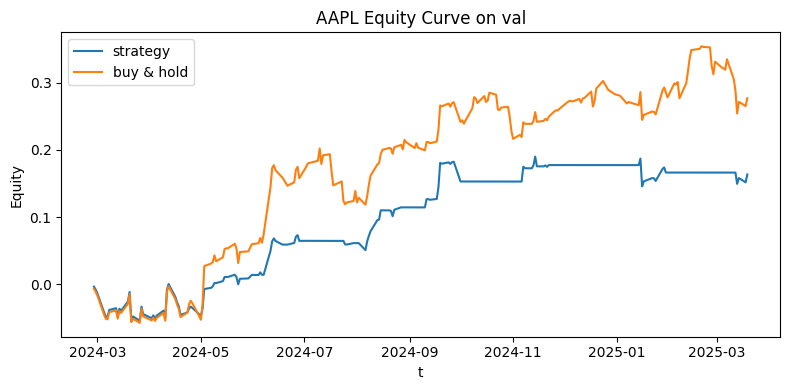

Metrics on val:
Sharpe ratio: 1.662886481134981, annual return: 0.2926476032763112, volatility: 0.17598772170940283
[I 2025-07-04 15:31:46,860] Trial 2 finished with value: 1.25181481777738 and parameters: {'window_size': 30, 'num_actions': 5, 'learning_rate': 1.3667272915456215e-05, 'batch_size': 256, 'gamma': 0.9353185793426654, 'exploration_fraction': 0.2123738038749523, 'buffer_size': 56556, 'mlp_dim': 45, 'mlp_layer1': 436, 'mlp_layer2': 78, 'dropout': 0.4947547746402069, 'linear_dim': 103, 'rnn_dim': 76, 'rnn_hidden': 66, 'lstm_dim': 215, 'lstm_hidden': 381}. Best is trial 1 with value: 1.3963904989643114.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 101, 'hidden_layers': [420, 172], 'dropout': 0.40838687198182444}}
Logging to save/logs//MLP_3\MLP_3_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 925      |
|    ep_rew_mean      | 54.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 355      |
|    time_elapsed     | 260      |
|    total_timesteps  | 92500    |
| train/              |          |
|    learning_rate    | 1.55e-05 |
|    loss             | 0.212    |
|    n_updates        | 20624    |
----------------------------------


Обучение завершено


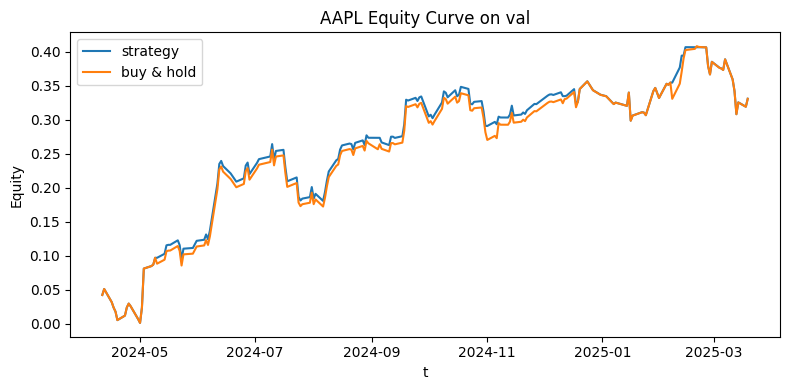

Metrics on val:
Sharpe ratio: 2.460209143236492, annual return: 0.6718679752041238, volatility: 0.27309384531441006
[I 2025-07-04 15:36:33,455] Trial 3 finished with value: 1.9237067928267813 and parameters: {'window_size': 60, 'num_actions': 5, 'learning_rate': 1.551225912648474e-05, 'batch_size': 128, 'gamma': 0.9878340615150564, 'exploration_fraction': 0.28888597006477973, 'buffer_size': 16361, 'mlp_dim': 101, 'mlp_layer1': 420, 'mlp_layer2': 172, 'dropout': 0.40838687198182444, 'linear_dim': 71, 'rnn_dim': 149, 'rnn_hidden': 255, 'lstm_dim': 37, 'lstm_hidden': 112}. Best is trial 3 with value: 1.9237067928267813.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 109, 'hidden_layers': [199, 236], 'dropout': 0.31573689676626027}}
Logging to save/logs//MLP_4\MLP_4_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 925      |
|    ep_rew_mean      | 43.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 349      |
|    time_elapsed     | 264      |
|    total_timesteps  | 92500    |
| train/              |          |
|    learning_rate    | 4.86e-05 |
|    loss             | 0.375    |
|    n_updates        | 20624    |
----------------------------------


Обучение завершено


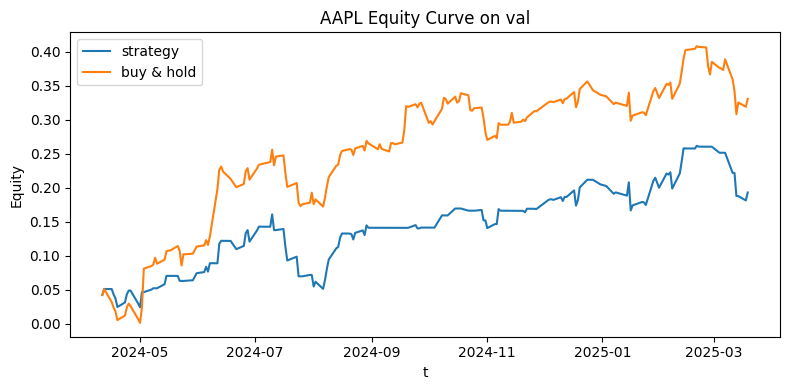

Metrics on val:
Sharpe ratio: 1.877375267796429, annual return: 0.39190215033772613, volatility: 0.20875003365614891
[I 2025-07-04 15:41:24,212] Trial 4 finished with value: 1.4317333325588182 and parameters: {'window_size': 60, 'num_actions': 3, 'learning_rate': 4.857295179217165e-05, 'batch_size': 256, 'gamma': 0.9800039175768773, 'exploration_fraction': 0.35336150260416943, 'buffer_size': 87789, 'mlp_dim': 109, 'mlp_layer1': 199, 'mlp_layer2': 236, 'dropout': 0.31573689676626027, 'linear_dim': 107, 'rnn_dim': 233, 'rnn_hidden': 206, 'lstm_dim': 56, 'lstm_hidden': 166}. Best is trial 3 with value: 1.9237067928267813.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 56, 'hidden_layers': [319, 122], 'dropout': 0.21393619775098704}}
Logging to save/logs//MLP_5\MLP_5_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 895      |
|    ep_rew_mean      | 59.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 471      |
|    time_elapsed     | 189      |
|    total_timesteps  | 89500    |
| train/              |          |
|    learning_rate    | 0.000103 |
|    loss             | 0.473    |
|    n_updates        | 19874    |
----------------------------------


Обучение завершено


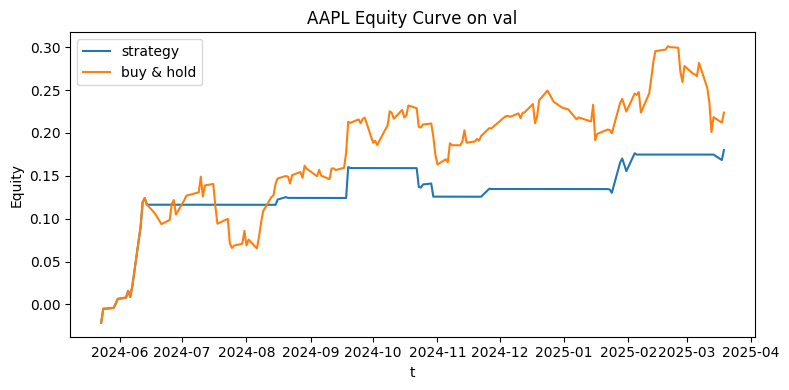

Metrics on val:
Sharpe ratio: 2.6546779010620605, annual return: 0.4216735387245453, volatility: 0.15884169546740334
[I 2025-07-04 15:45:03,157] Trial 5 finished with value: 1.9847765923608058 and parameters: {'window_size': 90, 'num_actions': 3, 'learning_rate': 0.00010300196600986775, 'batch_size': 32, 'gamma': 0.9359993306355501, 'exploration_fraction': 0.4887128330883843, 'buffer_size': 96433, 'mlp_dim': 56, 'mlp_layer1': 319, 'mlp_layer2': 122, 'dropout': 0.21393619775098704, 'linear_dim': 20, 'rnn_dim': 169, 'rnn_hidden': 289, 'lstm_dim': 43, 'lstm_hidden': 189}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 63, 'hidden_layers': [199, 71], 'dropout': 0.33635717727529674}}
Logging to save/logs//MLP_6\MLP_6_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 955      |
|    ep_rew_mean      | 62.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 740      |
|    time_elapsed     | 128      |
|    total_timesteps  | 95500    |
| train/              |          |
|    learning_rate    | 5.16e-05 |
|    loss             | 0.415    |
|    n_updates        | 21374    |
----------------------------------


Обучение завершено


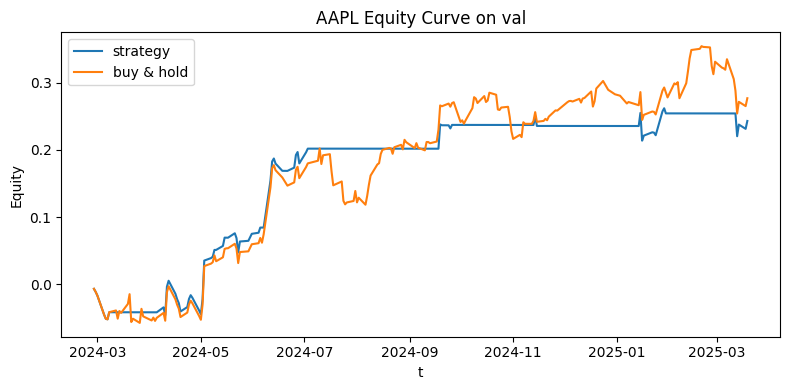

Metrics on val:
Sharpe ratio: 2.1500075745679785, annual return: 0.43511018346920083, volatility: 0.20237611653839482
[I 2025-07-04 15:47:21,243] Trial 6 finished with value: 1.635538357238345 and parameters: {'window_size': 30, 'num_actions': 3, 'learning_rate': 5.163124910488014e-05, 'batch_size': 32, 'gamma': 0.9530416937234011, 'exploration_fraction': 0.13611590802176332, 'buffer_size': 84354, 'mlp_dim': 63, 'mlp_layer1': 199, 'mlp_layer2': 71, 'dropout': 0.33635717727529674, 'linear_dim': 92, 'rnn_dim': 35, 'rnn_hidden': 293, 'lstm_dim': 82, 'lstm_hidden': 353}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 119, 'hidden_layers': [474, 186], 'dropout': 0.2356119164194803}}
Logging to save/logs//MLP_7\MLP_7_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | 36.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 208      |
|    time_elapsed     | 414      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 0.00429  |
|    loss             | 0.441    |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


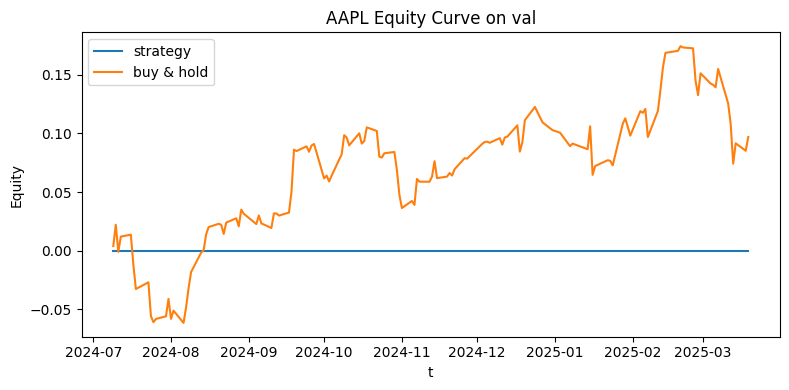

Metrics on val:
Sharpe ratio: nan, annual return: 0.0, volatility: 0.0
[W 2025-07-04 15:55:32,111] Trial 7 failed with parameters: {'window_size': 120, 'num_actions': 19, 'learning_rate': 0.0042856634196503434, 'batch_size': 128, 'gamma': 0.9524354072572446, 'exploration_fraction': 0.19674091636018068, 'buffer_size': 13844, 'mlp_dim': 119, 'mlp_layer1': 474, 'mlp_layer2': 186, 'dropout': 0.2356119164194803, 'linear_dim': 55, 'rnn_dim': 195, 'rnn_hidden': 466, 'lstm_dim': 231, 'lstm_hidden': 414} because of the following error: The value nan is not acceptable.
[W 2025-07-04 15:55:32,112] Trial 7 failed with value nan.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 63, 'hidden_layers': [415, 189], 'dropout': 0.43968936419767124}}
Logging to save/logs//MLP_8\MLP_8_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 865      |
|    ep_rew_mean      | -18.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 228      |
|    time_elapsed     | 377      |
|    total_timesteps  | 86500    |
| train/              |          |
|    learning_rate    | 1.04e-05 |
|    loss             | 0.59     |
|    n_updates        | 19124    |
----------------------------------


Обучение завершено


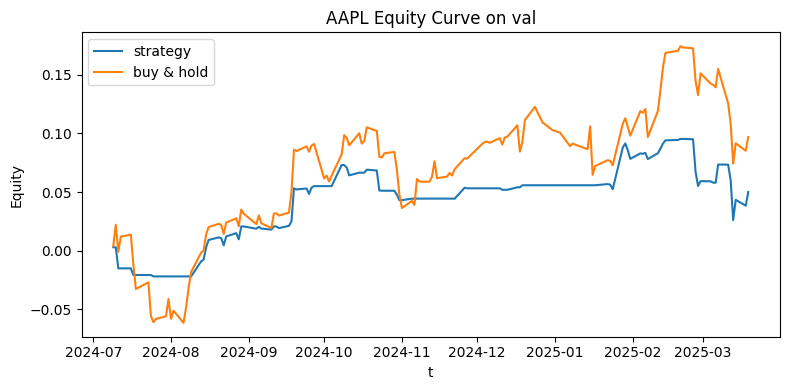

Metrics on val:
Sharpe ratio: 0.9807633023011488, annual return: 0.13559333381738609, volatility: 0.13825286233614745
[I 2025-07-04 16:02:59,565] Trial 8 finished with value: 0.72721231175602 and parameters: {'window_size': 120, 'num_actions': 19, 'learning_rate': 1.0355826161899173e-05, 'batch_size': 128, 'gamma': 0.9222026616365955, 'exploration_fraction': 0.3848716885390143, 'buffer_size': 27538, 'mlp_dim': 63, 'mlp_layer1': 415, 'mlp_layer2': 189, 'dropout': 0.43968936419767124, 'linear_dim': 90, 'rnn_dim': 159, 'rnn_hidden': 106, 'lstm_dim': 114, 'lstm_hidden': 183}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 124, 'hidden_layers': [480, 135], 'dropout': 0.10618264661154697}}
Logging to save/logs//MLP_9\MLP_9_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 925      |
|    ep_rew_mean      | 43.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 389      |
|    time_elapsed     | 237      |
|    total_timesteps  | 92500    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.78     |
|    n_updates        | 20624    |
----------------------------------


Обучение завершено


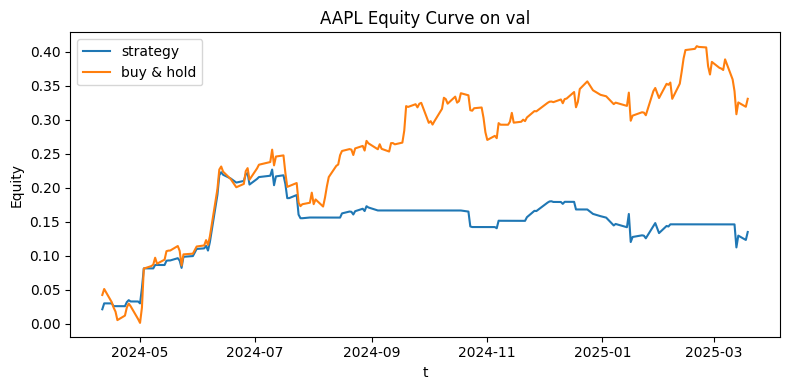

Metrics on val:
Sharpe ratio: 1.4806978320359365, annual return: 0.27410919623238345, volatility: 0.1851216300191968
[I 2025-07-04 16:07:22,060] Trial 9 finished with value: 1.1187212412948704 and parameters: {'window_size': 60, 'num_actions': 5, 'learning_rate': 0.0003002984436915126, 'batch_size': 64, 'gamma': 0.9639017572948096, 'exploration_fraction': 0.17084427176281958, 'buffer_size': 94344, 'mlp_dim': 124, 'mlp_layer1': 480, 'mlp_layer2': 135, 'dropout': 0.10618264661154697, 'linear_dim': 120, 'rnn_dim': 128, 'rnn_hidden': 498, 'lstm_dim': 248, 'lstm_hidden': 447}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 99, 'hidden_layers': [398, 133], 'dropout': 0.21743673770579736}}
Logging to save/logs//MLP_10\MLP_10_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 895      |
|    ep_rew_mean      | 36.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 292      |
|    time_elapsed     | 305      |
|    total_timesteps  | 89500    |
| train/              |          |
|    learning_rate    | 0.000513 |
|    loss             | 0.324    |
|    n_updates        | 19874    |
----------------------------------


Обучение завершено


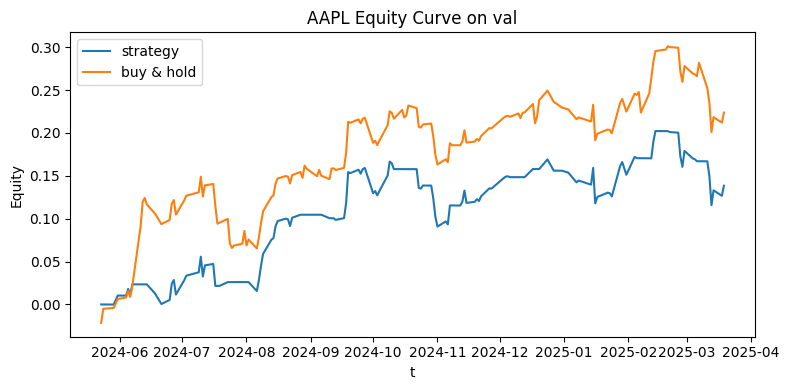

Metrics on val:
Sharpe ratio: 1.5472984358139585, annual return: 0.3240881031670429, volatility: 0.20945416583230492
[I 2025-07-04 16:13:10,493] Trial 10 finished with value: 1.1803353360198838 and parameters: {'window_size': 90, 'num_actions': 11, 'learning_rate': 0.0005130781383387443, 'batch_size': 128, 'gamma': 0.95131463558401, 'exploration_fraction': 0.45094922877118215, 'buffer_size': 75373, 'mlp_dim': 99, 'mlp_layer1': 398, 'mlp_layer2': 133, 'dropout': 0.21743673770579736, 'linear_dim': 107, 'rnn_dim': 214, 'rnn_hidden': 453, 'lstm_dim': 237, 'lstm_hidden': 293}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 33, 'hidden_layers': [298, 107], 'dropout': 0.11139131645598874}}
Logging to save/logs//MLP_11\MLP_11_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 895      |
|    ep_rew_mean      | 42.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 484      |
|    time_elapsed     | 184      |
|    total_timesteps  | 89500    |
| train/              |          |
|    learning_rate    | 0.00306  |
|    loss             | 0.244    |
|    n_updates        | 19874    |
----------------------------------


Обучение завершено


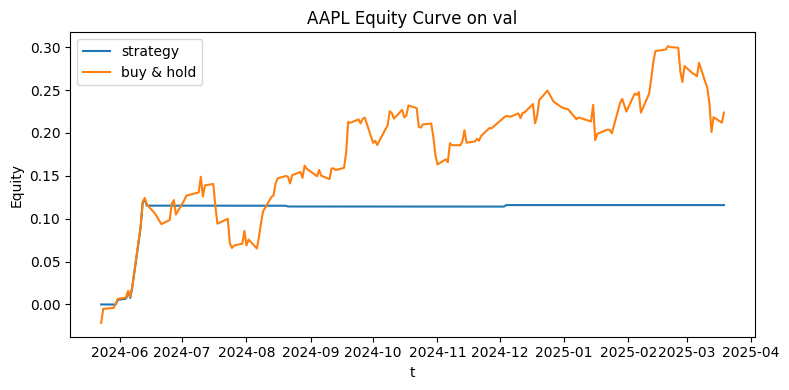

Metrics on val:
Sharpe ratio: 2.2964998825575784, annual return: 0.27128113727402237, volatility: 0.11812808671773174
[I 2025-07-04 16:16:42,287] Trial 11 finished with value: 1.6889342589725114 and parameters: {'window_size': 90, 'num_actions': 3, 'learning_rate': 0.0030636400452826182, 'batch_size': 32, 'gamma': 0.9029024132102538, 'exploration_fraction': 0.4630659181130072, 'buffer_size': 57459, 'mlp_dim': 33, 'mlp_layer1': 298, 'mlp_layer2': 107, 'dropout': 0.11139131645598874, 'linear_dim': 16, 'rnn_dim': 191, 'rnn_hidden': 373, 'lstm_dim': 183, 'lstm_hidden': 77}. Best is trial 5 with value: 1.9847765923608058.
Shape of data: (1396, 6) 2019-11-13 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.MLPFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 85, 'hidden_layers': [335, 186], 'dropout': 0.3945648410595614}}
Logging to save/logs//MLP_12\MLP_12_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 895      |
|    ep_rew_mean      | 53.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 360      |
|    time_elapsed     | 248      |
|    total_timesteps  | 89500    |
| train/              |          |
|    learning_rate    | 6.32e-05 |
|    loss             | 0.619    |
|    n_updates        | 19874    |
----------------------------------


Обучение завершено


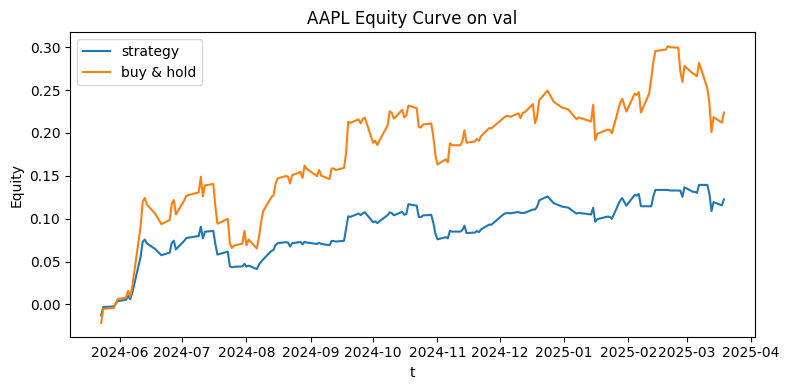

Metrics on val:
Sharpe ratio: 2.0298737303984287, annual return: 0.2869290902875642, volatility: 0.14135317187007737
[I 2025-07-04 16:21:27,239] Trial 12 finished with value: 1.5069903383651693 and parameters: {'window_size': 90, 'num_actions': 11, 'learning_rate': 6.323728543271084e-05, 'batch_size': 64, 'gamma': 0.9960196337460396, 'exploration_fraction': 0.2998567125885048, 'buffer_size': 41240, 'mlp_dim': 85, 'mlp_layer1': 335, 'mlp_layer2': 186, 'dropout': 0.3945648410595614, 'linear_dim': 47, 'rnn_dim': 164, 'rnn_hidden': 207, 'lstm_dim': 32, 'lstm_hidden': 67}. Best is trial 5 with value: 1.9847765923608058.
Лучшие параметры: {'window_size': 90, 'num_actions': 3, 'learning_rate': 0.00010300196600986775, 'batch_size': 32, 'gamma': 0.9359993306355501, 'exploration_fraction': 0.4887128330883843, 'buffer_size': 96433, 'mlp_dim': 56, 'mlp_layer1': 319, 'mlp_layer2': 122, 'dropout': 0.21393619775098704, 'linear_dim': 20, 'rnn_dim': 169, 'rnn_hidden': 289, 'lstm_dim': 43, 'lstm_hidden'

TypeError: DQN.__init__() got an unexpected keyword argument 'mlp_dim'

In [7]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    CONFIG["num_actions"] = best_params["num_actions"]
    del best_params["window_size"]
    del best_params["num_actions"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

# Тест на большом окне данных

In [6]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 60,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2010-11-13", "2022-01-11"),
    "val_period": ("2022-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 3600,  # 1 час
        "direction": "maximize"
    }
}

Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_76


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.75e+03 |
|    ep_rew_mean      | -93.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 960      |
|    time_elapsed     | 286      |
|    total_timesteps  | 274800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 66199    |
----------------------------------


Обучение завершено


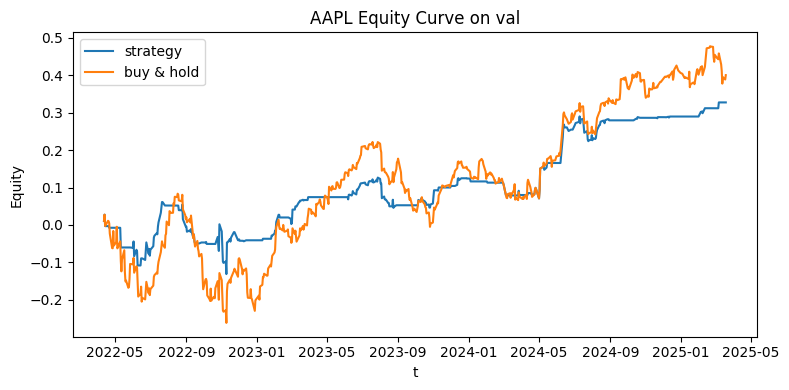

Metrics on val:
Sharpe ratio: 1.073887630671922, annual return: 0.20846172396707688, volatility: 0.19411874949769578


In [9]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)